# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Описание представленных данных:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

**Основная цель исследования** - научиться определять рыночную стоимость объектов недвижимости, что как уже говорилось ранее позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
Само исследование разделено на следующие этапы:
1. [Анализ первичных данных](#section1)
2. [Предабработка данных](#section2)
3. [Расчет дополнительных метрик](#section3)
4. [Исследовательский анализ данных](#section4)
5. [Общий вывод](#section5)

<a id = 'section1'></a>
# 1. Анализ первичных данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [4]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

# Вывод

## Итак, по массиву данных основные пропуски приходятся на следующие параметры:
- `высота потолков (м)`, 38.7% всех квартир с отсутствующим параметром
- `всего этажей в доме`, 3.6% всех квартир с отсутствующим параметром
- `жилая площадь в квадратных метрах`, 8% всех квартир с отсутствующим параметром
- `является ли квартира аппартаментами`, почти полностью отсутствуют данные 88.2 % пропусков
- `имеется ли балкон` 48.6% всех квартир с отсутствующим параметром
- `название населённого пункта`, 2% пропусков 
- а так же столбцы с данными — получены автоматически на основе картографических данных


<a id = 'section2'></a>
# 2. Предобработка данных

Заполняем пропуски. Диаметр СПб в самом узком месте 25 тыс. м, применена логичная замена к пропускам, все что меньше 12.5 тыс. м до центра является СПб, остальное отнесем к категории Другое. Произведена леммитизация по названию населённого пункта и выделены несколько категорий.  

In [5]:
def spb_locality(row):
    if pd.isna(row['locality_name']) and row['cityCenters_nearest'] <= 12500:
        return 'Санкт-Петербург'
    elif pd.isna(row['locality_name']):
        return 'Другое'
    return row['locality_name']

In [6]:
df['locality_name'] = df.apply(spb_locality, axis = 1)

In [7]:
from pymystem3 import Mystem
m = Mystem()

In [8]:
def find_lemmas(text):
    lemmas = m.lemmatize(text)
    return lemmas
df['lemmas'] = df['locality_name'].apply(find_lemmas)

In [9]:
def locality_group(locality):
    for element in locality:
        if element == 'село':
            return 'село'
        elif element == 'поселок':
            return 'поселок'
        elif element == 'деревня':
            return 'деревня'
        elif element == 'другой':
            return 'другое'
        elif element == 'товарищество':
            return 'товарищество'
        elif element == 'санкт-петербург':
            return 'город федерального значения'
        else:
            return 'город'         

In [10]:
df['lemmas'] = df['lemmas'].apply(locality_group)
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,lemmas
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,город федерального значения
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,поселок
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,город федерального значения
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,город федерального значения
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,город федерального значения
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,город федерального значения
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,город
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,село
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,город федерального значения


Сгруппируем данные по нескольким параметрам и определим медианное значение для пропущенных категорий, затем заменим пропуски. Пропущенные значения в поле высота потолков заполним медианными значениями в целом по всему Датасету, так как высота потолка в среденем везде одинакова, не вижу смысла более детально привязываться к расположению квартиры

In [11]:
group_lemmas = df.groupby('lemmas')

In [12]:
df['ceiling_height'] = group_lemmas.ceiling_height.apply(lambda x: x.fillna(x.median()))

In [13]:
df['floors_total'] = df['floors_total'].fillna('Unknown')

Считаю, что высота дома больше относиться к категориальной переменной и пропущенное значение сложно спрогнозировать на основании медианы или среднего значения. Заполнил все пропуски параметром Unknown

In [17]:
group_living_area = df.groupby(['rooms', 'lemmas'])['living_area'].median().to_dict()

In [20]:
group_living_area

{(0, 'город'): 18.0,
 (0, 'город федерального значения'): 18.7,
 (0, 'деревня'): 17.0,
 (0, 'поселок'): 16.64,
 (1, 'город'): 17.5,
 (1, 'город федерального значения'): 17.9,
 (1, 'деревня'): 17.1,
 (1, 'другое'): 18.0,
 (1, 'поселок'): 17.0,
 (1, 'село'): 18.35,
 (2, 'город'): 30.0,
 (2, 'город федерального значения'): 31.0,
 (2, 'деревня'): 30.0,
 (2, 'другое'): 31.95,
 (2, 'поселок'): 30.0,
 (2, 'село'): 29.7,
 (3, 'город'): 43.0,
 (3, 'город федерального значения'): 45.8,
 (3, 'деревня'): 44.8,
 (3, 'другое'): 46.45,
 (3, 'поселок'): 44.150000000000006,
 (3, 'село'): 38.7,
 (4, 'город'): 53.9,
 (4, 'город федерального значения'): 65.5,
 (4, 'деревня'): 55.5,
 (4, 'поселок'): 53.3,
 (5, 'город'): 72.7,
 (5, 'город федерального значения'): 95.0,
 (5, 'деревня'): 92.0,
 (5, 'поселок'): 65.8,
 (6, 'город'): 81.9,
 (6, 'город федерального значения'): 123.9,
 (6, 'деревня'): 147.2,
 (7, 'город'): 239.4,
 (7, 'город федерального значения'): 145.0,
 (7, 'поселок'): nan,
 (8, 'город'): 160.

In [15]:
def median_leaving_area(row):
    if np.isnan(row['living_area']):
        return group_living_area.get((row['rooms'], row['lemmas']))
    return row['living_area']

In [16]:
df['living_area'] = df.apply(median_leaving_area, axis = 1)

In [17]:
df[df['living_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,lemmas
2462,18,7900000.0,201.5,2018-08-17T00:00:00,7,2.6,2,NaN,2,NaN,...,NaN,посёлок Парголово,54990.0,20665.0,0.0,NaN,0.0,NaN,35.0,поселок


In [18]:
df['living_area'] = df['living_area'].fillna(df[df['rooms'] == 7]['living_area'].median())

In [19]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.000000
floors_total            0.000000
living_area             0.000000
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.000000
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
lemmas                  0.000000
dtype: float64

Заполнил пропущенные значения жилой площади медианными значениями. Медианные значения получены на основе сгруппирированных данных: кол-ва комнат в квартире и территориальный признак. Пропущенные значения которые не попали в данную группировку(в моем случае 7 комнатная квартира) заполнены медианными значениями по категории с соответсвующим признаком

In [20]:
group_kitchen_area = df.groupby(['rooms', 'lemmas'])['kitchen_area'].median().to_dict()

In [21]:
def median_kitchen_area(row):
    if np.isnan(row['kitchen_area']):
        return group_kitchen_area.get((row['rooms'], row['lemmas']))
    return row['kitchen_area']

In [22]:
df['kitchen_area'] = df.apply(median_kitchen_area, axis = 1)

In [23]:
df[df['kitchen_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,lemmas
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.60,24,15.50,2,NaN,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,поселок
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.65,14,17.00,1,NaN,...,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,деревня
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.70,17,24.75,4,NaN,...,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,город федерального значения
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.60,26,24.30,19,NaN,...,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,поселок
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.60,10,16.64,7,NaN,...,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0,поселок
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.70,25,18.00,16,NaN,...,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,город федерального значения
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,2.60,24,18.00,4,NaN,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0,поселок
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.70,19,18.70,8,NaN,...,NaN,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,город федерального значения
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,2.56,9,18.00,8,NaN,...,2.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0,город


In [24]:
df['kitchen_area'] = group_lemmas.kitchen_area.apply(lambda x: x.fillna(x.median()))

In [25]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.000000
floors_total            0.000000
living_area             0.000000
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.000000
balcony                 0.486054
locality_name           0.000000
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
lemmas                  0.000000
dtype: float64

Заполнил пропущенные значения по кухонной площади медианными значениями. Медианные значения получены на основе сгруппирированных данных: кол-ва комнат в квартире и территориальный признак. Пропущенные значения которые не попали в данную группировку заполнены медианными значениями по всей категории, сгруппирированные по территориальному признаку

In [26]:
df['area_check'] = (df['living_area'] + df['kitchen_area']).round(2) > df['total_area'].round(2)
df[['living_area', 'kitchen_area','total_area', 'area_check']][(df['area_check'] == True)]

,living_area,kitchen_area,total_area,area_check
184,26.10,6.2,30.2,True
227,44.15,9.7,47.0,True
237,20.75,9.4,28.1,True
322,17.50,8.4,25.0,True
349,17.00,9.4,25.0,True
...,...,...,...,...
23420,20.30,9.8,29.9,True
23554,18.70,9.6,26.0,True
23579,18.00,8.4,24.8,True
23613,44.15,9.7,52.0,True


In [27]:
def living_area_control(row):
    if row['area_check'] is True:
        return row['total_area'] - row['kitchen_area']
    return row['living_area']

In [28]:
df['living_area'] = df.apply(living_area_control, axis = 1)

In [29]:
df['area_check'] = (df['living_area'] + df['kitchen_area']).round(2) > df['total_area'].round(2)
df[['living_area', 'kitchen_area','total_area', 'area_check']][(df['area_check'] == True)]

,living_area,kitchen_area,total_area,area_check


При проверке данных на логичность, имеются значения кухни и жилой площади, в сумме которые превышают общую площадь квартиры. Присвоена логическая переменная и данные отредактированы с помощью функции, если сумма значений превышает общую площадь, то жилая площадь расчитывается как разность общей площади и кухни. Таких строк 427 штук, что составляет 2% всех данных. Данные измениния не сильно искозят выборку

Логичная замена, если человек не указал число балконов — скорее всего, их нет. Такие пропуски правильно заменить на 0

In [30]:
df['balcony'] = df['balcony'].fillna(0)

In [31]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.000000
floors_total            0.000000
living_area             0.000000
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.000000
balcony                 0.000000
locality_name           0.000000
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
lemmas                  0.000000
area_check              0.000000
dtype: float64

Добавим столбец стоимость квартиры в млн руб. для удобства построения графиков

In [32]:
df['last_price_mln_rub'] = (df['last_price'] / 1000000).round(2)
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,lemmas,area_check,last_price_mln_rub
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16,51.0,8,NaN,...,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,город федерального значения,False,13.00
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.60,11,18.6,1,NaN,...,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,поселок,False,3.35
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.70,5,34.3,4,NaN,...,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,город федерального значения,False,5.20
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.70,14,45.8,9,NaN,...,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,город федерального значения,False,64.90
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14,32.0,13,NaN,...,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,город федерального значения,False,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5,73.3,3,NaN,...,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,город федерального значения,False,9.70
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.56,5,38.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,город,False,3.10
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.60,3,29.7,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,село,False,2.50
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17,31.0,12,NaN,...,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,город федерального значения,False,11.48


Переведем значения цены квартиры, наличие балкона, кол-во парков и водоемов в ближайшее 3000 м, сколько дней было размещено объявление до целочисленного значения. Сами по себе значения предполагаются быть целочисленными

In [33]:
df[[
    'last_price', 'balcony','parks_around3000', 'ponds_around3000','days_exposition']] = df[[
    'last_price', 'balcony', 'parks_around3000', 'ponds_around3000','days_exposition']].apply(lambda x: x.round(0).astype('Int64'))

Перевод даты в читаемый вид

In [34]:
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')

 Логичная замена, если 0 комнат, то скорее всего обычная студия или однокомнатная квартира

In [35]:
def zero_room(row):
    room = row['rooms']
    if room == 0:
        return 1
    return row['rooms']
df['rooms'] = df.apply(zero_room, axis = 1)

In [36]:
df['rooms'].value_counts()

1     8244
2     7940
3     5814
4     1180
5      326
6      105
7       59
8       12
9        8
10       3
14       2
11       2
15       1
12       1
19       1
16       1
Name: rooms, dtype: int64

In [37]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.000000
floors_total            0.000000
living_area             0.000000
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.000000
balcony                 0.000000
locality_name           0.000000
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
lemmas                  0.000000
area_check              0.000000
last_price_mln_rub      0.000000
dtype: float64

In [38]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,lemmas,area_check,last_price_mln_rub
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,18863.0,16028.0,1,482.0,2,755.0,NaN,город федерального значения,False,13.00
1,7,3350000,40.4,2018-12-04,1,2.60,11,18.6,1,NaN,...,12817.0,18603.0,0,NaN,0,NaN,81,поселок,False,3.35
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.3,4,NaN,...,21741.0,13933.0,1,90.0,2,574.0,558,город федерального значения,False,5.20
3,0,64900000,159.0,2015-07-24,3,2.70,14,45.8,9,NaN,...,28098.0,6800.0,2,84.0,3,234.0,424,город федерального значения,False,64.90
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,31856.0,8098.0,2,112.0,1,48.0,121,город федерального значения,False,10.00


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
total_images            23699 non-null int64
last_price              23699 non-null Int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null object
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null Int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null Int64
parks_nearest           8079 non-null float64
ponds_around30

Завершена предобработка данных имеющегося Датасета. Перед анализом имеем отредактированный Датасет с пропусками в стобцах, где значения получены автоматически на основе картографических данных. Заполнить эти пропуски логичными заменами, на мой взгляд, не представляется возможным, так как это геоданные, а средние значения исказят выборку и не будут достоверными. Так же 88% данных не заполнены в булевом массиве - "является ли квартира аппартаментами", так как значение является категориальной переменной. Отстутсвует информация сколько дней было размещено объявление (от публикации до снятия) в 13% случаев. 
   Цена квартиры, наличие балкона, кол-во парков и водоемов в ближайшее 3000 м, сколько дней было размещено объявление  приведены к целочисленного значения (формат Int64). Дата размещения объявления приведена к формату datetime64. Остальные переменные имеют формат object, bool, float64.

<a id = 'section3'></a>
# 3. Расчет дополнительных метрик

In [40]:
df['price_per_meter^2'] = df['last_price']//df['total_area']

Поиск стоимости квадратного метра

In [41]:
df['weekday'] = df['first_day_exposition'].dt.weekday_name

In [42]:
df['weekday_number'] = df['first_day_exposition'].dt.weekday

In [43]:
df['month'] = df['first_day_exposition'].dt.month_name()

In [44]:
df['month_number'] = df['first_day_exposition'].dt.month

In [45]:
df['year'] = df['first_day_exposition'].dt.year

Выделяем день недели, месяц и год размещения объявления

In [46]:
def floor_group(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if (floor == 1) or (floor == 0):
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'

In [47]:
df['floor_group'] = df.apply(floor_group, axis = 1)

Применяем к параметру `этаж` категоризацию для удобства дальнейшего анализа

In [48]:
df['living_to_total_area'] = (df['living_area']/df['total_area']).round(3)

In [49]:
df['kitchen_to_total_area'] = (df['kitchen_area']/df['total_area']).round(3)

In [50]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,last_price_mln_rub,price_per_meter^2,weekday,weekday_number,month,month_number,year,floor_group,living_to_total_area,kitchen_to_total_area
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,...,13.00,120370.0,Thursday,3,March,3,2019,другой,0.472,0.231
1,7,3350000,40.40,2018-12-04,1,2.60,11,18.60,1,NaN,...,3.35,82920.0,Tuesday,1,December,12,2018,первый,0.460,0.272
2,10,5196000,56.00,2015-08-20,2,2.70,5,34.30,4,NaN,...,5.20,92785.0,Thursday,3,August,8,2015,другой,0.612,0.148
3,0,64900000,159.00,2015-07-24,3,2.70,14,45.80,9,NaN,...,64.90,408176.0,Friday,4,July,7,2015,другой,0.288,0.063
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,...,10.00,100000.0,Tuesday,1,June,6,2018,другой,0.320,0.410
5,10,2890000,30.40,2018-09-10,1,2.56,12,14.40,5,NaN,...,2.89,95065.0,Monday,0,September,9,2018,другой,0.474,0.299
6,6,3700000,37.30,2017-11-02,1,2.60,26,10.60,6,NaN,...,3.70,99195.0,Thursday,3,November,11,2017,другой,0.284,0.386
7,5,7915000,71.60,2019-04-18,2,2.70,24,31.00,22,NaN,...,7.92,110544.0,Thursday,3,April,4,2019,другой,0.433,0.264
8,20,2900000,33.16,2018-05-23,1,2.60,27,15.43,26,NaN,...,2.90,87454.0,Wednesday,2,May,5,2018,другой,0.465,0.266
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,NaN,...,5.40,88524.0,Sunday,6,February,2,2017,другой,0.715,0.107


Для удобства анализа расчитаны дополнительные метрики. Посчитана цена квадратного метра, определен день недели, месяц и год размещения объявления. Выделены категории для параметра `этаж` - Первый, Последний, Другой. Определена доля жилой площади и доля площади кухни в составе квартиры.

<a id = 'section4'></a>
# 4. Исследовательский анализ данных

Изучаем следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

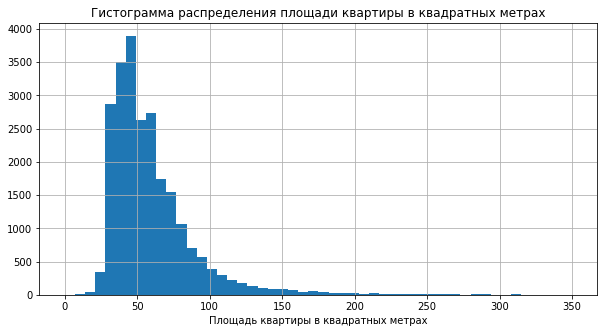

In [52]:
df.hist(column='total_area', bins = 50, range = (0,350), figsize = (10,5), grid = True)
plt.title('Гистограмма распределения площади квартиры в квадратных метрах')
plt.xlabel('Площадь квартиры в квадратных метрах')
plt.show()

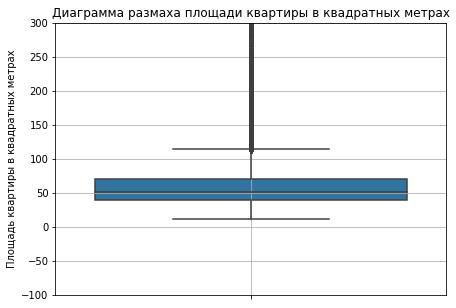

In [53]:
plt.figure(figsize=(7,5))
sns.boxplot(y= df['total_area'])
plt.grid()
plt.ylim(-100, 300)
plt.ylabel('Площадь квартиры в квадратных метрах')
plt.title('Диаграмма размаха площади квартиры в квадратных метрах')
plt.show()

Наблюдается небольшой пик в 50 кв.м. Основная часть значений лежит в диапозоне от 40 до 70 кв. м., что выглядит правдоподобно для рынка недвижимости. Очень мало значений свыше 200 кв. м. В целом распределение похоже на нормальное

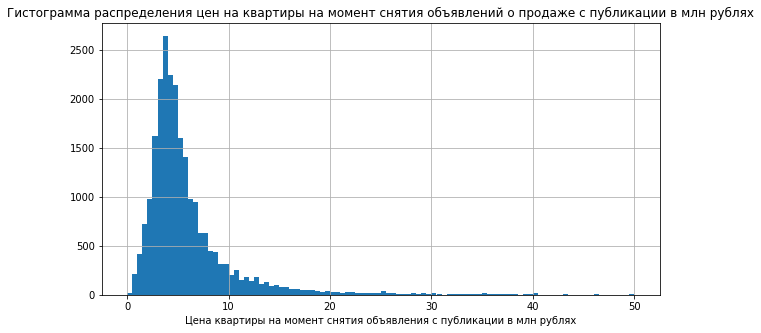

In [54]:
df.hist(column='last_price_mln_rub', bins = 100, range = (0,50), figsize = (10,5))
plt.title('Гистограмма распределения цен на квартиры на момент снятия объявлений о продаже с публикации в млн рублях')
plt.xlabel('Цена квартиры на момент снятия объявления с публикации в млн рублях')
plt.show()

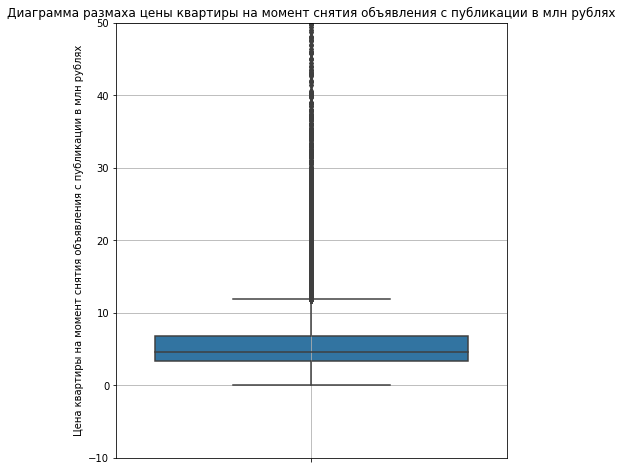

In [55]:
plt.figure(figsize=(7,8))
sns.boxplot(y= df['last_price_mln_rub'])
plt.grid()
plt.ylim(-10, 50)
plt.ylabel('Цена квартиры на момент снятия объявления с публикации в млн рублях')
plt.title('Диаграмма размаха цены квартиры на момент снятия объявления с публикации в млн рублях')
plt.show()

Наибольший пик в значении около 4 млн руб. Основная часть значений лежит от 3 до 6 млн. руб. Очень мало значений свыше 30 млн. руб.

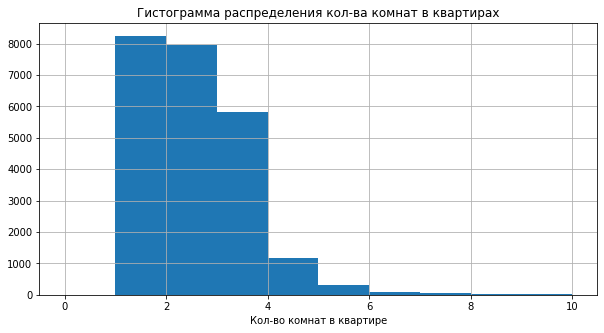

In [56]:
df.hist(column='rooms', bins = 10, range = (0,10), figsize = (10,5))
plt.title('Гистограмма распределения кол-ва комнат в квартирах')
plt.xlabel('Кол-во комнат в квартире')
plt.show()

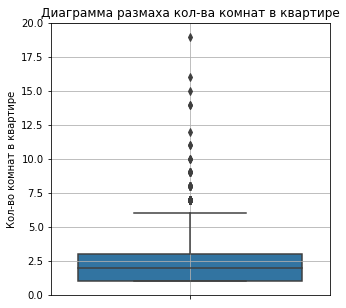

In [57]:
plt.figure(figsize=(5,5))
sns.boxplot(y= df['rooms'])
plt.grid()
plt.ylim(0, 20)
plt.ylabel('Кол-во комнат в квартире')
plt.title('Диаграмма размаха кол-ва комнат в квартире')
plt.show()

Наибольшие значения представлены 1 комнатными и 2 комнатными квартирами. Основная часть значений лежит от 1 до 4 комнат. Очень мало значений свыше 6  комнат. Все что свыше 6 комнат выбросы. 

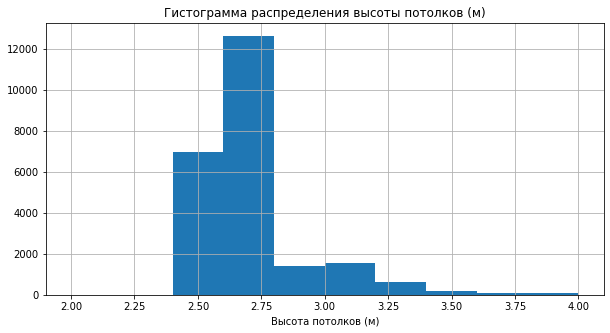

In [58]:
df.hist(column='ceiling_height', bins = 10, range = (2,4), figsize = (10,5))
plt.title('Гистограмма распределения высоты потолков (м)')
plt.xlabel('Высота потолков (м)')
plt.show()

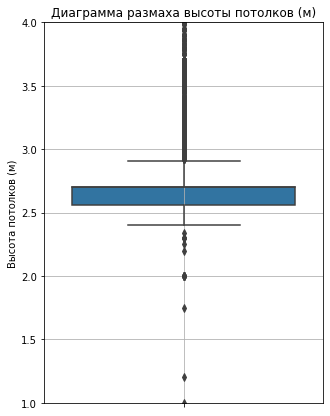

In [59]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df['ceiling_height'])
plt.grid()
plt.ylim(1, 4)
plt.ylabel('Высота потолков (м)')
plt.title('Диаграмма размаха высоты потолков (м)')
plt.show()

Пиковое значение 2,75 метров. Основная часть значений лежит от 2,56 до 2,70 метров. Очень мало значений свыше 2,9 метров. 

Изучаем время продажи квартиры. Построим гистограмму. Посчитаем среднее и медиану. Посмотрим, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

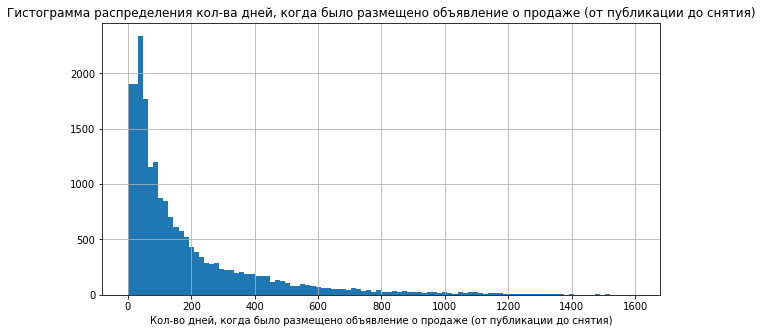

In [60]:
df.hist(column='days_exposition', bins = 100, range = (0,1600), figsize = (10,5))
plt.title('Гистограмма распределения кол-ва дней, когда было размещено объявление о продаже (от публикации до снятия)')
plt.xlabel('Кол-во дней, когда было размещено объявление о продаже (от публикации до снятия)')
plt.show()

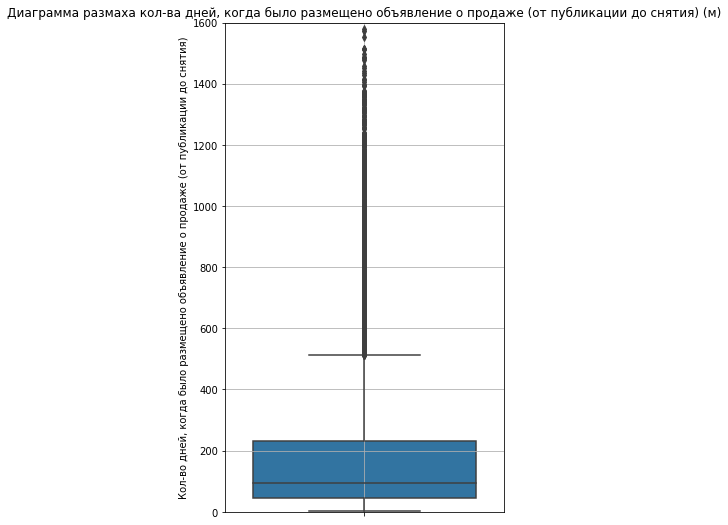

In [61]:
plt.figure(figsize=(5,9))
sns.boxplot(y= df['days_exposition'])
plt.grid()
plt.ylim(0, 1600)
plt.ylabel('Кол-во дней, когда было размещено объявление о продаже (от публикации до снятия)')
plt.title('Диаграмма размаха кол-ва дней, когда было размещено объявление о продаже (от публикации до снятия) (м)')
plt.show()

Распределение выглядит более менее адекватно. Наблюдается большой пик на отметке 45 дней. Быстрой продажей можно считать все, что реализуется быстрее 30 дней. Согласно методикам применяемым для оценки недвижимости, срок экспоцзиции высоколиквидной недвижемости 30 дней. Среднее значение в 2 раза больше медианы, что говорит о том, что в распределении длинный хвост высоких значений, влияющих на среднюю и медиану. Слишком долгая продажа - продажа свыше 1200 дней, так как дольше данного значения, квартиры практически не реализуются. 

Воспользуемся диаграммой размаха для поиска границ нормальных значений для следующих параметров:
- ceiling_height - высота потолков (м)
- kitchen_area - площадь кухни в квадратных метрах (м²)
- last_price - цена на момент снятия с публикации
- living_area - жилая площадь в квадратных метрах(м²)
- total_area - площадь квартиры в квадратных метрах (м²)
- days_exposition - сколько дней было размещено объявление

In [62]:
def normal_borders(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    print(q1 - 1.5 *iqr, q3 + 1.5 *iqr)

In [63]:
normal_borders('ceiling_height')

2.3499999999999996 2.91


In [64]:
normal_borders('kitchen_area')

1.2350000000000012 17.674999999999997


In [65]:
normal_borders('last_price')

-1700000.0 11900000.0


In [66]:
normal_borders('living_area')

-18.150000000000002 79.05000000000001


In [67]:
normal_borders('total_area')

-4.8500000000000085 114.75000000000001


In [68]:
normal_borders('days_exposition')

-235.5 512.5


Избавимся от выбивающихся значений

Экспертные оценки
- высота потолков примем от 2,35 м до 4 м 
- цену на момент снятия с публикации примем от 1,2 млн рублей(самая маленкая квартира в спб 11 м кв.) до 50 млн рублей
- общую площадь примем от 11 м кв до 250 м кв
- площадь кухни примем от 3,5 м кв до 20 м кв
- жилую площадь примем от 11 м кв до 200 м кв
- сколько дней было размещено объявление примем согласно диаграммы размах до 512 дней ( среднесрочная экспозиция 270 дней, в приципе соответсвует рынку)

Действительно в центре СПб старая застройка, высота потолков может доходить до 4 м. Элитная недвижимость конечно стоит и выше 50 млн. р (самая дорогая квартира СПб 262 млн), но в среднем объявления за 50 млн. рублей встречаются чаще. Границы площади взяты экспертно. 

In [69]:
good_data = df.query('2.35 < ceiling_height < 4 and 3.5 < kitchen_area < 20 and last_price < 50000000 and living_area < 200 and total_area < 250 and days_exposition < 512.5')

In [70]:
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,last_price_mln_rub,price_per_meter^2,weekday,weekday_number,month,month_number,year,floor_group,living_to_total_area,kitchen_to_total_area
1,7,3350000,40.40,2018-12-04,1,2.60,11,18.60,1,NaN,...,3.35,82920.0,Tuesday,1,December,12,2018,первый,0.460,0.272
5,10,2890000,30.40,2018-09-10,1,2.56,12,14.40,5,NaN,...,2.89,95065.0,Monday,0,September,9,2018,другой,0.474,0.299
6,6,3700000,37.30,2017-11-02,1,2.60,26,10.60,6,NaN,...,3.70,99195.0,Thursday,3,November,11,2017,другой,0.284,0.386
8,20,2900000,33.16,2018-05-23,1,2.60,27,15.43,26,NaN,...,2.90,87454.0,Wednesday,2,May,5,2018,другой,0.465,0.266
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,NaN,...,5.40,88524.0,Sunday,6,February,2,2017,другой,0.715,0.107


Какие факторы больше всего влияют на стоимость квартиры? Изучаем, зависит ли цена от площади, числа комнат, удалённости от центра. Изучение зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также следует проверить зависимость от даты размещения: дня недели, месяца и года.

Text(0.5, 1.0, 'Диаграмма рассеиния общей площади квартир к цене квартиры, млн руб')

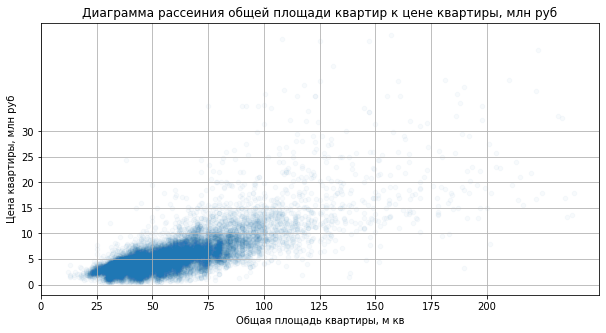

In [71]:
good_data.plot(x = 'total_area', 
                       y = 'last_price_mln_rub', kind = 'scatter', grid = True, alpha=0.03, figsize=(10,5))
plt.xticks(np.arange(0, 225, 25))
plt.yticks(np.arange(0, 35, 5))
plt.ylabel('Цена квартиры, млн руб')
plt.xlabel('Общая площадь квартиры, м кв')
plt.title('Диаграмма рассеиния общей площади квартир к цене квартиры, млн руб')

Text(0.5, 0, 'Общая площадь квартиры, м кв')

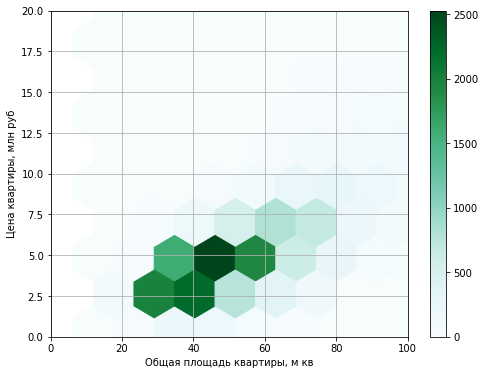

In [72]:
good_data.plot(x='total_area', y='last_price_mln_rub',
               kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)
plt.ylim(0, 20)
plt.xlim(0, 100)
plt.ylabel('Цена квартиры, млн руб')
plt.xlabel('Общая площадь квартиры, м кв')

In [73]:
good_data['last_price_mln_rub'].corr(good_data['total_area'])

0.7534783666536864

Наибольшее скопление данных на промежутке с площадью квартиры от 30 до 60 кв.м. и стоимостью квартиры от 2 до 8 млн рублей. Стоимость квартиры с небольшой площадью примерно до отметки  в 75 кв.м. увеличивается более менее равномерно относительно ее площади, затем идет сильный разброс, на стоимость влияют какие-то другие параметры.  Корреляция в 0,75 говорит о наличии связи. Увеличение площади квартиры увеличивает ее стоимость, но так бывает не всегда.

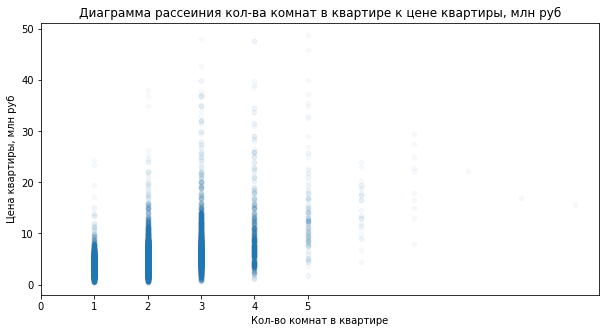

In [74]:
good_data.plot(x = 'rooms', 
                       y = 'last_price_mln_rub', kind = 'scatter', alpha=0.03, figsize = (10,5))
plt.xticks(np.arange(0, 6, 1))
plt.ylabel('Цена квартиры, млн руб')
plt.xlabel('Кол-во комнат в квартире')
plt.title('Диаграмма рассеиния кол-ва комнат в квартире к цене квартиры, млн руб')
plt.show()

In [75]:
good_data['last_price_mln_rub'].corr(good_data['rooms'])

0.48224996229022027

По диаграмме рассеяния видно, что кол-во комнат практически не влияет на цену квартиры. Стоимость квартир одинаково варьируется относительно их стоимости. Коэффициент корреляции 0,48 - зависимость низкая. На практике данная тенденция так же подтверждается: 3х комнтаная квартира и 2ух комнатная квартира с одинаковой площадью в одном доме и на одном этаже будут стоить примерно одинаково.

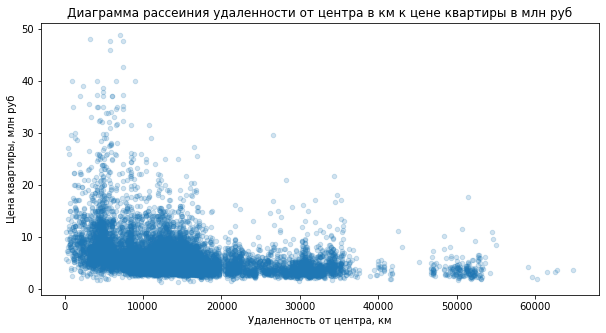

In [76]:
good_data.plot(x = 'cityCenters_nearest', 
                       y = 'last_price_mln_rub', kind = 'scatter', alpha=0.2, figsize = (10,5))
plt.ylabel('Цена квартиры, млн руб')
plt.xlabel('Удаленность от центра, км')
plt.title('Диаграмма рассеиния удаленности от центра в км к цене квартиры в млн руб')
plt.show()

In [77]:
good_data['last_price_mln_rub'].corr(good_data['cityCenters_nearest'])

-0.3232779630652027

Очевидно, что чем дальше квартира от центра, тем меньше ее стоимость, что отчетливо видно на диаграмме рассеиния, так же подтвержедно отрицательной корреляцией. Значение корреляции близко к 0, но взаимосвязь величин явно есть, скорее всего зависимость нелинейна. 

In [78]:
import warnings
warnings.filterwarnings('ignore')

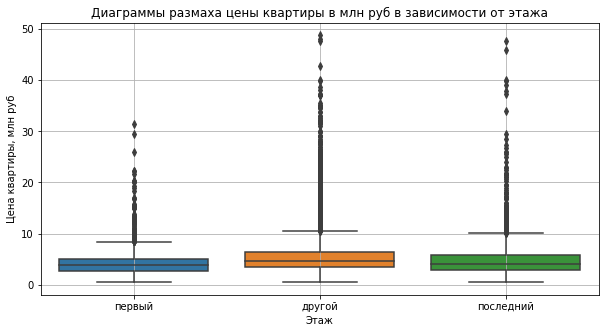

In [79]:
plt.figure(figsize=(10,5))
sns.boxplot(x='floor_group', y='last_price_mln_rub', data=good_data)
plt.grid()
plt.title('Диаграммы размаха цены квартиры в млн руб в зависимости от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена квартиры, млн руб')
plt.show()

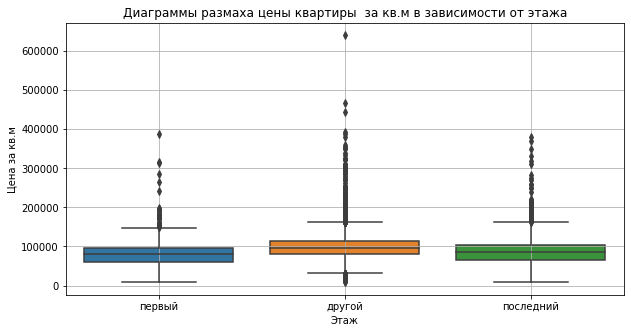

In [80]:
plt.figure(figsize=(10,5))
sns.boxplot(x='floor_group', y='price_per_meter^2', data=good_data)
plt.grid()
plt.title('Диаграммы размаха цены квартиры  за кв.м в зависимости от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена за кв.м')
plt.show()

In [81]:
good_data.groupby('floor_group')['price_per_meter^2'].agg(['mean', 'median']).round()

,mean,median
floor_group,,
другой,98160.0,96250.0
первый,79219.0,80000.0
последний,86795.0,86144.0


Квартиры на первом и последнем этажах заметно теряют в стоимости. Если в среднем квартиры на первом этаже стоят 79 тыс. р. за кв м, на последнем 86 тыс. р. за кв м, то на любом другом этаже стоимость достигает до 98 тыс. р. за кв м

In [82]:
good_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'lemmas', 'area_check',
       'last_price_mln_rub', 'price_per_meter^2', 'weekday', 'weekday_number',
       'month', 'month_number', 'year', 'floor_group', 'living_to_total_area',
       'kitchen_to_total_area'],
      dtype='object')

In [83]:
weekday_price = (good_data.groupby(['weekday_number', 'weekday'])
                        .agg(['mean', 'median']).reset_index().sort_values('weekday_number'))

In [84]:
weekday_price.set_index('weekday')['price_per_meter^2'].round(2)

,mean,median
weekday,,
Monday,93691.41,93128.0
Tuesday,94298.73,93317.0
Wednesday,94744.57,93676.0
Thursday,94821.82,93437.0
Friday,94321.75,92510.0
Saturday,94439.54,92559.0
Sunday,93516.80,92598.5


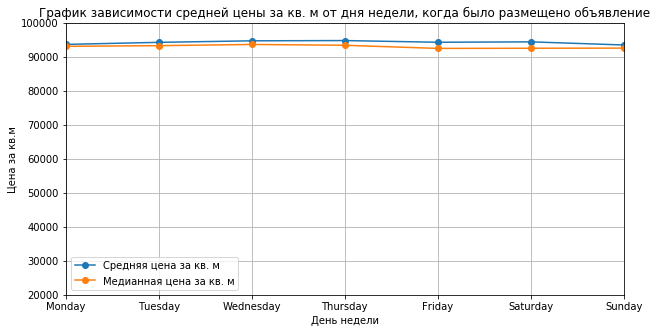

In [85]:
weekday_price.plot(x='weekday', y='price_per_meter^2',
                   ylim = (20000, 100000), style='o-',figsize = (10,5), title = 'weekday_price')
plt.title('График зависимости средней цены за кв. м от дня недели, когда было размещено объявление')
plt.xlabel('День недели')
plt.ylabel('Цена за кв.м')
plt.grid()
plt.legend(['Средняя цена за кв. м', 'Медианная цена за кв. м'])
plt.show()

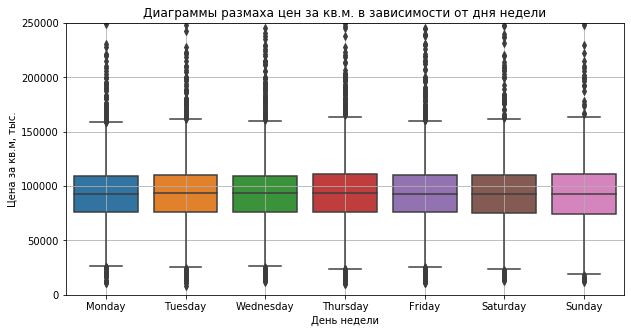

In [87]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday', y='price_per_meter^2', data=good_data, order=weekday_price['weekday'])
plt.grid()
plt.ylim(0, 250_000)
plt.title('Диаграммы размаха цен за кв.м. в зависимости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Цена за кв.м, тыс.')
plt.show()

Сильной зависимости нет между днем недели, в который было размещено объявление, и стоимостью квартиры. График ровный, есть небольшие просадки по цене в Пятницу и небольшой скачок вверх в Среду.

In [88]:
month_price = (good_data.groupby(['month_number', 'month'])
                        .agg(['mean', 'median']).reset_index().sort_values('month_number'))

In [89]:
month_price.set_index('month')['price_per_meter^2'].round(2)

,mean,median
month,,
January,95086.96,94278.0
February,93639.44,93023.0
March,94749.01,93877.0
April,93843.43,92000.0
May,93848.35,91649.0
June,93839.54,90909.0
July,93529.79,93189.5
August,96071.76,95000.0
September,96150.48,94444.0


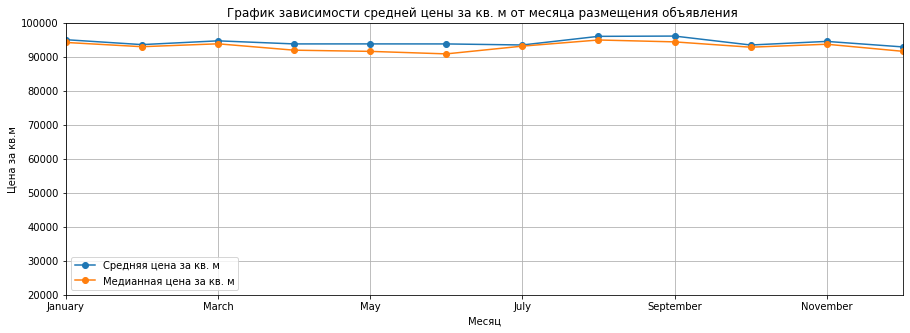

In [90]:
month_price.plot(x='month', y='price_per_meter^2', ylim = (20000, 100000),
                 style='o-',figsize = (15,5))
plt.title('График зависимости средней цены за кв. м от месяца размещения объявления ')
plt.xlabel('Месяц')
plt.ylabel('Цена за кв.м')
plt.grid()
plt.legend(['Средняя цена за кв. м', 'Медианная цена за кв. м'])
plt.show()

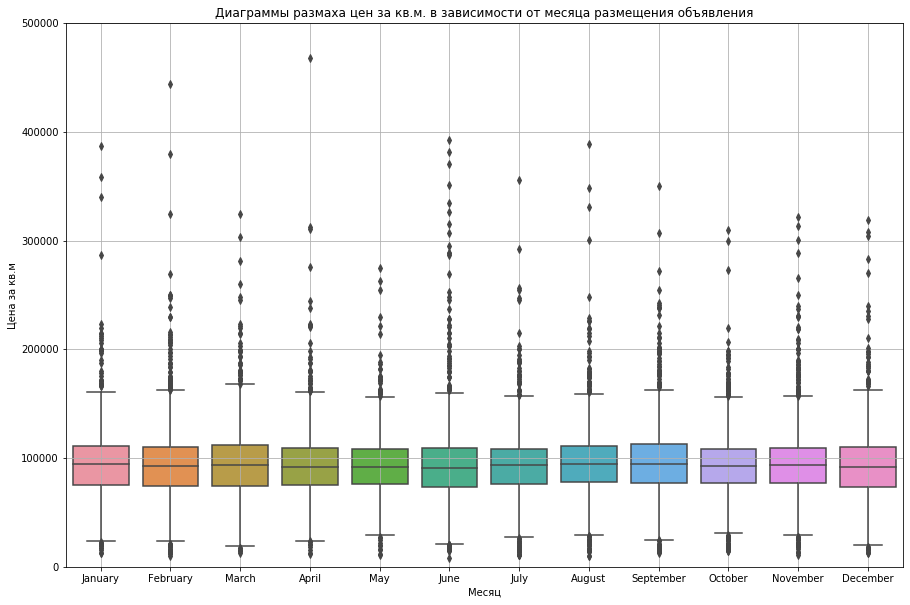

In [91]:
plt.figure(figsize=(15,10))
sns.boxplot(x='month', y='price_per_meter^2', data=good_data, order=month_price['month'])
plt.grid()
plt.ylim(0, 500_000)
plt.title('Диаграммы размаха цен за кв.м. в зависимости от месяца размещения объявления')
plt.xlabel('Месяц')
plt.ylabel('Цена за кв.м')
plt.show()

Согласно текущим данным к летнему периоду (весной) спрос на недвижимость падает, поэтому и цена снижется, так как продают квартиры лишь те, кому срочно нужны деньги. Согласно статистике в летний период спросом пользуется загорадная недвижимость, поэтому весной цена на недвижку и падает. В целом цена на одном уровне. Есть так же незначительное падение в сентябре.

In [92]:
year_price = (good_data.groupby('year').agg(['mean', 'median'])).reset_index()

In [93]:
year_price.set_index('year')['price_per_meter^2'].round(2)

,mean,median
year,,
2015,90846.67,89552.0
2016,93832.73,90697.0
2017,92836.32,91071.0
2018,94817.46,94827.0
2019,103800.04,103024.0


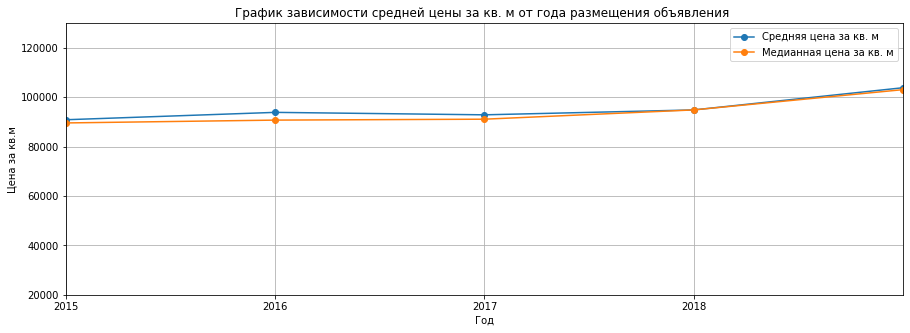

In [94]:
year_price.plot(x='year', y='price_per_meter^2', ylim = (20000, 130000), style='o-',figsize = (15,5), title = 'year_price')
plt.xticks(np.arange(2015, 2019, 1))
plt.title('График зависимости средней цены за кв. м от года размещения объявления ')
plt.xlabel('Год')
plt.ylabel('Цена за кв.м')
plt.grid()
plt.legend(['Средняя цена за кв. м', 'Медианная цена за кв. м'])
plt.show()

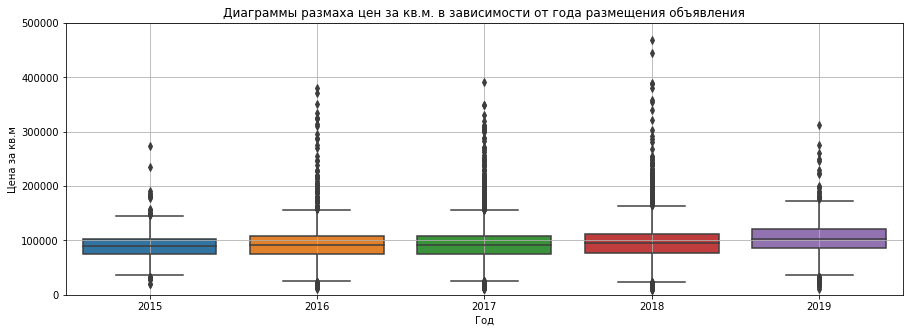

In [95]:
plt.figure(figsize=(15,5))
sns.boxplot(x='year', y='price_per_meter^2', data=good_data, order=year_price['year'])
plt.grid()
plt.ylim(0, 500_000)
plt.title('Диаграммы размаха цен за кв.м. в зависимости от года размещения объявления')
plt.xlabel('Год')
plt.ylabel('Цена за кв.м')
plt.show()

Цена квартиры из года в год стремться к росту

Выбираем 10 населённых пунктов с наибольшим числом объявлений. Считаем среднюю цену квадратного метра в этих населённых пунктах. Выделяем среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [96]:
top_10 = df['locality_name'].value_counts().head(10).index

In [97]:
df_top_10 = df.query('locality_name in @top_10')

In [98]:
df_top10 = df_top_10.groupby('locality_name')['price_per_meter^2'].agg('mean').sort_values(ascending = False)
df_top10

locality_name
Санкт-Петербург      114836.826084
Пушкин               103125.368564
деревня Кудрово       92473.076923
посёлок Парголово     90175.486239
посёлок Мурино        85751.729885
посёлок Шушары        78676.902273
Колпино               75424.147929
Гатчина               68745.693811
Всеволожск            68654.007538
Выборг                58141.489451
Name: price_per_meter^2, dtype: float64

Очевидно, что самый дорогой кв. м непосредственно в самом СПб, цена составила 114 тыс. р за кв. м. Замыкает список топ 10 Выборг, здесь самая низкая цена, цена за кв. м составила 58 тыс. р. Опять таки прослеживается точная зависимость, чем дальше районы расположены от СПб, тем ниже цена за кв. м. 

Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге ('locality_name'). Задача — выяснить, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах. После этого посчитаем среднюю цену для каждого километра. Построим график зависимости цены от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [99]:
df_spb = df.query('locality_name == "Санкт-Петербург"')

In [100]:
df_spb = df_spb.dropna()

In [101]:
df_spb['cityCenters_nearest_km'] = (df_spb['cityCenters_nearest']/1000).round(0).astype('Int64')

In [102]:
df_spb['price_per_km'] = df_spb['last_price'] // df_spb['cityCenters_nearest_km']

In [103]:
df_mean_price_per_km = df_spb.groupby('cityCenters_nearest_km')['price_per_km'].agg('mean')

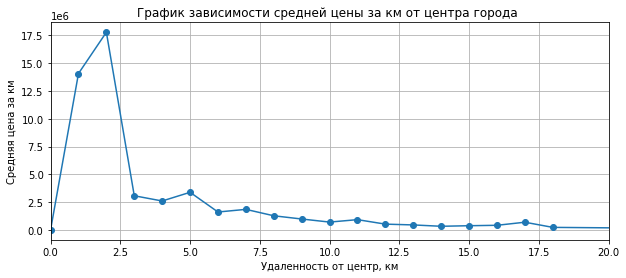

In [104]:
df_mean_price_per_km.plot(x='cityCenters_nearest_km', y='price_per_km',style='o-',
                          xlim = (0, 20), figsize = (10,4), title = 'mean_price_per_km')
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.title('График зависимости средней цены за км от центра города ')
plt.xlabel('Удаленность от центр, км')
plt.ylabel('Средняя цена за км')
plt.grid()
plt.show()

Сильное изменение графика происходит в точке 3 км. Примем радиус 3 км за центр.

Выделим сегмент квартир в центре. Произведем анализ этой территории и посмотрим на следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

In [105]:
center = df_spb.query('cityCenters_nearest_km <=6')

In [106]:
center = center[['total_area', 'price_per_meter^2', 'rooms', 'ceiling_height']]

In [107]:
labels = {'total_area':'Общая площадь, кв. м',
          'price_per_meter^2':'Цена за кв. м',
          'rooms':'Кол-во комнат',
          'ceiling_height':'Высота потолка, м'}

In [108]:
hist_name = {'total_area':'Диаграмма распределения общей площади',
          'price_per_meter^2':'Диаграмма распределения цены за кв. м',
          'rooms':'Диаграмма распределения кол-ва комнат',
          'ceiling_height':'Диаграмма распределения высоты потолка'}

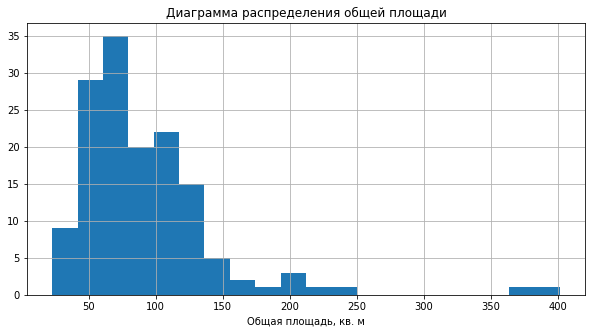

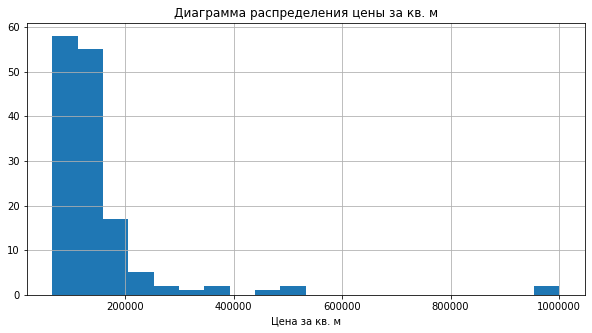

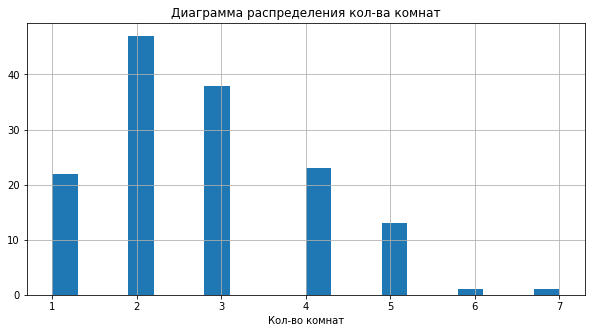

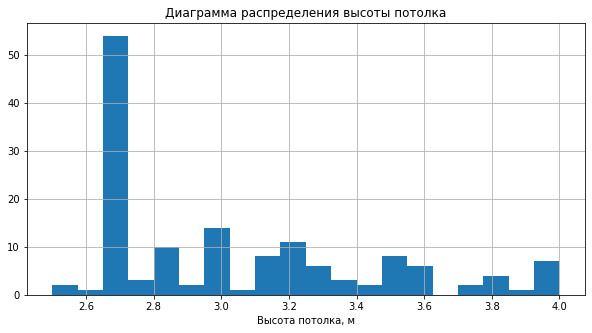

In [109]:
for column in center.columns:
    center.hist(column = column, bins = 20, figsize = (10,5))
    plt.xlabel(labels.get(column))
    plt.title(hist_name.get(column))

Распределения похоже на нормальные. В целом средняя квартира в центре представляет из себя 2-3 комнатную квартиру, с общей площадью от 50 до 125 м кв, со средней ценой 100 т.р. за квадратный метр и 2,7 метровыми потолками.

In [110]:
center_corr = df_spb.query('cityCenters_nearest_km <=6')[['rooms', 'floor', 'cityCenters_nearest',
                                                          'first_day_exposition', 'price_per_meter^2',
                                                          'last_price', 'total_area']]

In [111]:
center_corr[['last_price', 'total_area']]=center_corr[['last_price', 'total_area']].astype('int')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f713c3195d0>,
      dtype=object)

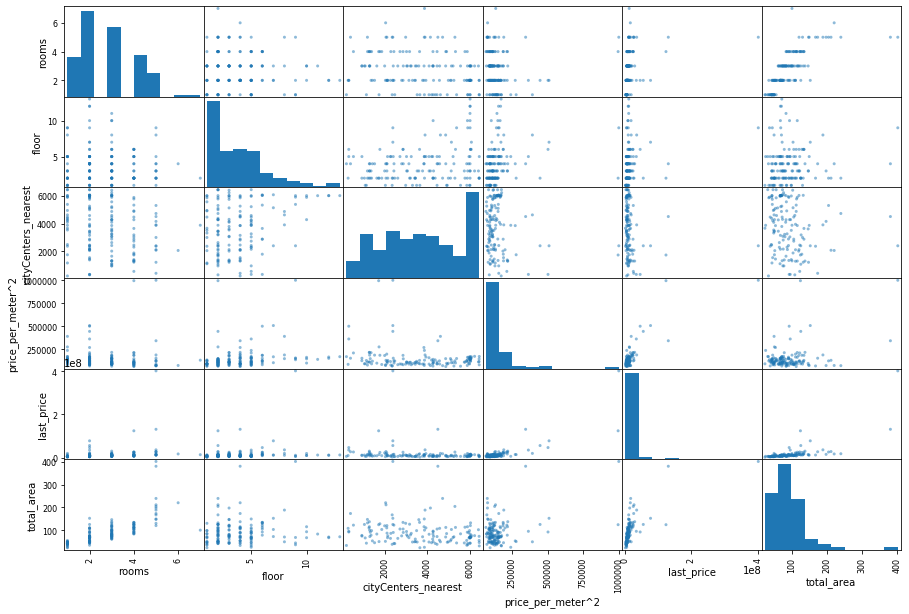

In [112]:
pd.plotting.scatter_matrix(center_corr, figsize = (15, 10))
plt.show()

In [113]:
center_corr.corr()

,rooms,floor,cityCenters_nearest,price_per_meter^2,last_price,total_area
rooms,1.000000,-0.071652,-0.225282,0.022514,0.260206,0.723038
floor,-0.071652,1.000000,0.252136,0.215038,0.184325,0.083284
cityCenters_nearest,-0.225282,0.252136,1.000000,-0.185825,-0.141852,-0.187878
price_per_meter^2,0.022514,0.215038,-0.185825,1.000000,0.808954,0.370528
last_price,0.260206,0.184325,-0.141852,0.808954,1.000000,0.674763
total_area,0.723038,0.083284,-0.187878,0.370528,0.674763,1.000000


Линейной зависимости, как таковой нет. Видно, что на квартиру в центре СПб больше всего влияет этаж. 

Просмотрена корреляция между ценой за квартиру и общей площадью, действительно имеется прямая зависимость. Коэффициент корреляции составил 0,72. Очевидно чем больше площадь квартиры в центре, тем дороже она будет стоить. 

In [114]:
df_spb['is_center'] = df_spb['cityCenters_nearest_km'] <= 6

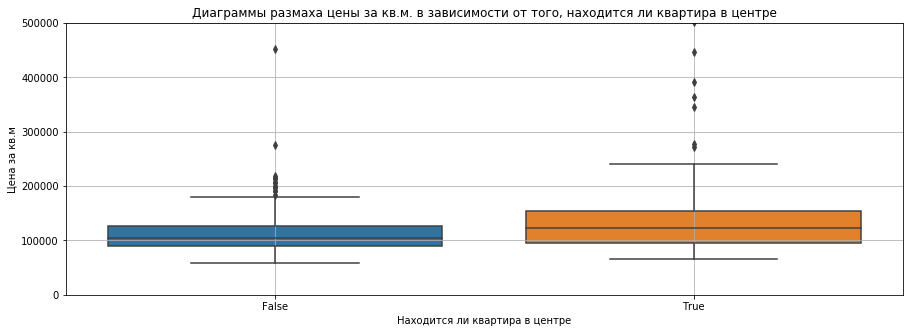

In [115]:
plt.figure(figsize=(15,5))
sns.boxplot(x='is_center', y='price_per_meter^2', data=df_spb)
plt.grid()
plt.ylim(0, 500_000)
plt.title('Диаграммы размаха цены за кв.м. в зависимости от того, находится ли квартира в центре')
plt.xlabel('Находится ли квартира в центре')
plt.ylabel('Цена за кв.м')
plt.show()

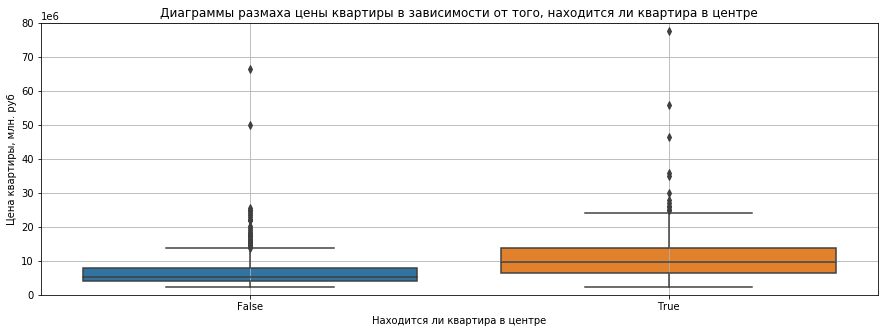

In [116]:
plt.figure(figsize=(15,5))
sns.boxplot(x='is_center', y='last_price', data=df_spb)
plt.grid()
plt.ylim(0, 80_000_000)
plt.title('Диаграммы размаха цены квартиры в зависимости от того, находится ли квартира в центре')
plt.xlabel('Находится ли квартира в центре')
plt.ylabel('Цена квартиры, млн. руб')
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

In [117]:
df_spb.groupby('is_center')[['price_per_meter^2', 'last_price_mln_rub']].agg(['mean', 'median'])

price_per_meter^2           last_price_mln_rub       
                       mean    median               mean median
is_center                                                      
False         114541.255663  103968.0           7.510453   5.24
True          151218.331034  122860.0          16.336414   9.75

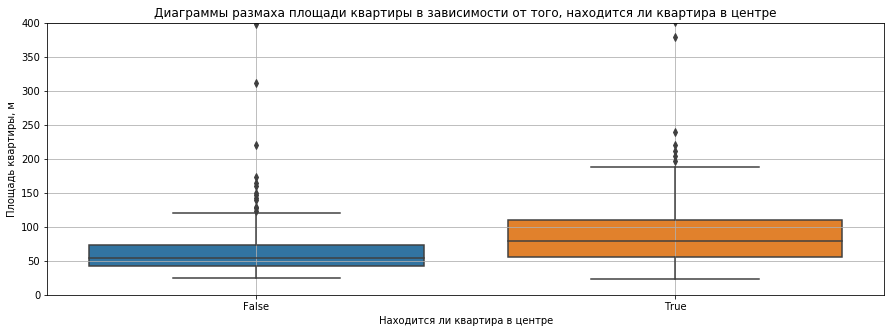

In [118]:
plt.figure(figsize=(15,5))
sns.boxplot(x='is_center', y='total_area', data=df_spb)
plt.grid()
plt.ylim(0, 400)
plt.title('Диаграммы размаха площади квартиры в зависимости от того, находится ли квартира в центре')
plt.xlabel('Находится ли квартира в центре')
plt.ylabel('Площадь квартиры, м')
plt.show()

In [119]:
df_spb.groupby('is_center')['total_area'].agg(['mean', 'median'])

,mean,median
is_center,,
False,63.267282,54.3
True,91.697586,79.0


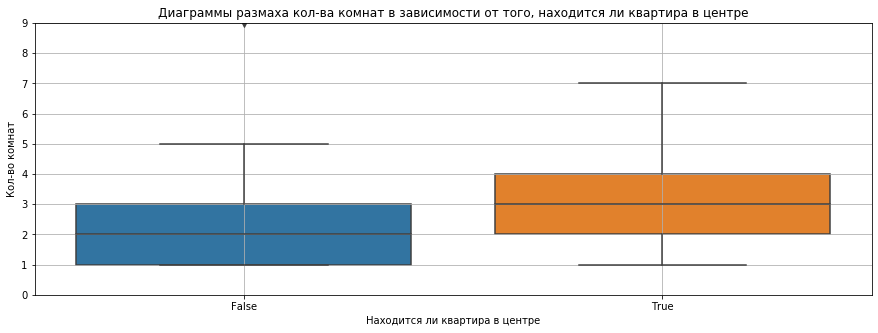

In [120]:
plt.figure(figsize=(15,5))
sns.boxplot(x='is_center', y='rooms', data=df_spb)
plt.grid()
plt.ylim(0, 9)
plt.title('Диаграммы размаха кол-ва комнат в зависимости от того, находится ли квартира в центре')
plt.xlabel('Находится ли квартира в центре')
plt.ylabel('Кол-во комнат')
plt.show()

In [121]:
df_spb.groupby('is_center')['rooms'].agg(['mean', 'median'])

,mean,median
is_center,,
False,2.100324,2
True,2.758621,3


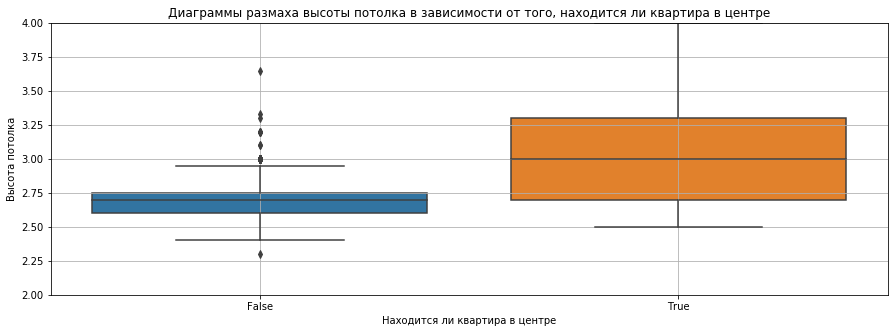

In [122]:
plt.figure(figsize=(15,5))
sns.boxplot(x='is_center', y='ceiling_height', data=df_spb)
plt.grid()
plt.ylim(2, 4)
plt.title('Диаграммы размаха высоты потолка в зависимости от того, находится ли квартира в центре')
plt.xlabel('Находится ли квартира в центре')
plt.ylabel('Высота потолка')
plt.show()

In [123]:
df_spb.groupby('is_center')['ceiling_height'].agg(['mean', 'median'])

,mean,median
is_center,,
False,3.104239,2.7
True,3.044000,3.0


In [124]:
total_stats = df_spb.groupby('is_center')[['ceiling_height', 'price_per_meter^2',
                             'rooms', 'total_area', 'last_price_mln_rub']].agg(['mean', 'median'])
total_stats.index = [['Не центр', 'Центр']]
total_stats

ceiling_height        price_per_meter^2               rooms         \
                   mean median              mean    median      mean median   
Не центр       3.104239    2.7     114541.255663  103968.0  2.100324      2   
Центр          3.044000    3.0     151218.331034  122860.0  2.758621      3   

         total_area        last_price_mln_rub         
               mean median               mean median  
Не центр  63.267282   54.3           7.510453   5.24  
Центр     91.697586   79.0          16.336414   9.75

По сравнению со Всем городом, в центральном районе все больше, дороже и выше. Основной параметр, который сильно влияет на цену за кв м это удаленность от центра. В центральном районе на цену за кв м влияет в большей степени этаж и площадь квартиры.

<a id = 'section5'></a>
# 5. Общий вывод

In [125]:
total_stats

ceiling_height        price_per_meter^2               rooms         \
                   mean median              mean    median      mean median   
Не центр       3.104239    2.7     114541.255663  103968.0  2.100324      2   
Центр          3.044000    3.0     151218.331034  122860.0  2.758621      3   

         total_area        last_price_mln_rub         
               mean median               mean median  
Не центр  63.267282   54.3           7.510453   5.24  
Центр     91.697586   79.0          16.336414   9.75

In [126]:
df_top10

locality_name
Санкт-Петербург      114836.826084
Пушкин               103125.368564
деревня Кудрово       92473.076923
посёлок Парголово     90175.486239
посёлок Мурино        85751.729885
посёлок Шушары        78676.902273
Колпино               75424.147929
Гатчина               68745.693811
Всеволожск            68654.007538
Выборг                58141.489451
Name: price_per_meter^2, dtype: float64

В целом распределение стоимость квартиры по городу СПБ нормальное, в ходе анализа были удалены хвосты распределения, которые в большей степени искажали средние значения. 
- Наиболее значимой переменной влияющей на стоимость квартиры это удаленность от центра. Центром СПб можно считать площадь радиусом 5-6 км от центральной точки города. Здесь средняя цена за кв. м составляет 173 тыс. руб. В целом по городу цена за кв м около 118 тыс. руб. 

- Выделены 10 населенных пунктов, где больше всего объявлений. В этот список попали: Спб, Пушкин, Кудрово, Парголово, Мурино, Шушары, Колпино, Гатчина, Всеволожск, Выборг. Самый дешевый район - Выборг с 58 тыс.руб за кв.м, самый дорогой естественно СПБ.

- Следует отметить, что наряду с удаленностью от центра, влияет и площадь недвижимости. Если в целом по городу это не так заметно, то в центральном районе города, данный параметр определяет цену квартиры.  

- Первые и последние этажи, в меньшей степени пользуются популярностью и занчительно снижают стоимость квартиры. Средняя цена квартиры за кв.м на первом этаже 79 тыс.руб, на последнем 86 тыс.руб, на других этажах 98 тыс. руб.

- Дома центра в основном невысотной застройки, квартиры в данном районе в основном двух\трехкомнатные, по крайней мере то, что продают. В остальных районах города продают преемущественно однакомнатные квартиры.

- Очевидный факт, что со временем цена недвижимости повышается, определенно присутсвует сезонность в летнее время наблюдается небольшой спад, снижение цены, так как спросом больше пользуется загородная недвижимость.